# Text Classification in scikit-learn

First, let's get the corpus we will be using, which is included in NLTK. You will need NLTK and Scikit-learn (as well as their dependencies, in particular scipy and numpy) to run this code.

In [8]:
import nltk
nltk.download("reuters") # if necessary
from nltk.corpus import reuters


[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\winnc\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


The NLTK sample of the Reuters Corpus contains 10,788 news documents totaling 1.3 million words. The documents have been classified into 90 topics, and is divided into a training and test sets, a split which we will preserve here. Let's look at the counts of texts the various categories.

In [9]:
for category in reuters.categories():
    print (category, len(reuters.fileids(category)))

acq 2369
alum 58
barley 51
bop 105
carcass 68
castor-oil 2
cocoa 73
coconut 6
coconut-oil 7
coffee 139
copper 65
copra-cake 3
corn 237
cotton 59
cotton-oil 3
cpi 97
cpu 4
crude 578
dfl 3
dlr 175
dmk 14
earn 3964
fuel 23
gas 54
gnp 136
gold 124
grain 582
groundnut 9
groundnut-oil 2
heat 19
hog 22
housing 20
income 16
instal-debt 6
interest 478
ipi 53
iron-steel 54
jet 5
jobs 67
l-cattle 8
lead 29
lei 15
lin-oil 2
livestock 99
lumber 16
meal-feed 49
money-fx 717
money-supply 174
naphtha 6
nat-gas 105
nickel 9
nkr 3
nzdlr 4
oat 14
oilseed 171
orange 27
palladium 3
palm-oil 40
palmkernel 3
pet-chem 32
platinum 12
potato 6
propane 6
rand 3
rape-oil 8
rapeseed 27
reserves 73
retail 25
rice 59
rubber 49
rye 2
ship 286
silver 29
sorghum 34
soy-meal 26
soy-oil 25
soybean 111
strategic-metal 27
sugar 162
sun-meal 2
sun-oil 7
sunseed 16
tea 13
tin 30
trade 485
veg-oil 124
wheat 283
wpi 29
yen 59
zinc 34


Many of the documents in the corpus are tagged with multiple labels; in this situation, a straightforward approach is to build a classifier for each label. Let's build a classifier to distinguish the most common topic in the corpus, "acq" (acqusitions). First, here's some code to build the dataset in preparation for classification using scikit-learn.

In [10]:
from sklearn.feature_extraction import DictVectorizer

def get_BOW(text):
    BOW = {}
    for word in text:
        BOW[word] = BOW.get(word,0) + 1
    return BOW

def prepare_reuters_data(topic,feature_extractor):
    training_set = []
    training_classifications = []
    test_set = []
    test_classifications = []
    for file_id in reuters.fileids():
        feature_dict = feature_extractor(reuters.words(file_id))   
        if file_id.startswith("train"):
            training_set.append(feature_dict)
            if topic in reuters.categories(file_id):
                training_classifications.append(topic)
            else:
                training_classifications.append("not " + topic)
        else:
            test_set.append(feature_dict)
            if topic in reuters.categories(file_id):
                test_classifications.append(topic)
            else:
                test_classifications.append("not " + topic)        
    vectorizer = DictVectorizer()
    training_data = vectorizer.fit_transform(training_set)
    test_data = vectorizer.transform(test_set)
    return training_data,training_classifications,test_data,test_classifications

trn_data,trn_classes,test_data,test_classes = prepare_reuters_data("acq",get_BOW)

The above code builds a sparse bag of words feature representation (a Python dictionary) for each text in the corpus (which is pre-tokenized), and places it the appropriate list depending on whether it is testing or training; a corresponding list of correct classifications is created at the same time. The scikit-learn DictVectorizer class converts Python dictionaries into the scipy sparse matrices which Scikit-learn uses; for the training set, use the fit_transform method (which fixes the total number of features in the model), and for the test set, use transform method (which ignores any features in the test set that weren't in the training set). Next, let's prepare some classifiers to test...

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

clfs = [KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier(),
        MultinomialNB(),LinearSVC(),LogisticRegression()]


To start, we are using default settings for all these classifiers. Let's start by doing 10-fold crossvalidation on the training set, and looking at the accuracy, recall, precision, and f1-score for each (be patient, this may take a while to complete)...

In [12]:
from sklearn import model_selection
#from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def do_multiple_10foldcrossvalidation(clfs,data,classifications):
    for clf in clfs:
        predictions = model_selection.cross_val_predict(clf, data,classifications, cv=10)
        print (clf)
        print ("accuracy")
        print (accuracy_score(classifications,predictions))
        print (classification_report(classifications,predictions))
        
do_multiple_10foldcrossvalidation(clfs,trn_data,trn_classes)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
accuracy
0.9258591839361565
              precision    recall  f1-score   support

         acq       0.85      0.79      0.82      1650
     not acq       0.95      0.96      0.95      6119

   micro avg       0.93      0.93      0.93      7769
   macro avg       0.90      0.88      0.89      7769
weighted avg       0.92      0.93      0.92      7769

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
accuracy
0.9358990861114687
              precision    recall  f1-score   support

         acq       0.85      0.85      0.85  

C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: F

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
accuracy
0.9474835886214442
              precision    recall  f1-score   support

         acq       0.89      0.86      0.87      1650
     not acq       0.96      0.97      0.97      6119

   micro avg       0.95      0.95      0.95      7769
   macro avg       0.92      0.92      0.92      7769
weighted avg       0.95      0.95      0.95      7769

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
accuracy
0.9549491569056506
              precision    recall  f1-score   support

         acq       0.84      0.98      0.90      1650
     not acq       0.

C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
accuracy
0.9769597116746042
              precision    recall  f1-score   support

         acq       0.95      0.94      0.95      1650
     not acq       0.98      0.99      0.99      6119

   micro avg       0.98      0.98      0.98      7769
   macro avg       0.97      0.96      0.97      7769
weighted avg       0.98      0.98      0.98      7769



C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
accuracy
0.9769597116746042
              precision    recall  f1-score   support

         acq       0.95      0.94      0.95      1650
     not acq       0.98      0.99      0.99      6119

   micro avg       0.98      0.98      0.98      7769
   macro avg       0.97      0.96      0.97      7769
weighted avg       0.98      0.98      0.98      7769



In this case, the classifiers are not obviously biased towards a particular task, so accuracy and f-score are nearly the same. The numbers are generally quite high, indicating that it is a fairly easy classification task. In terms of the best classifier, the clear standouts here are the SVM and Logistic Regression classifiers, while <i>k</i>NN is clearly the worst. One reason <i>k</i>NN might be doing poorly is that it is particularly susceptible to a noisy feature space with dimensions that are irrelevant to the task. Let's try to improve performance by removing stopwords and doing lowercasing

In [13]:
from nltk.corpus import stopwords

stopwords = stopwords.words('english')

def get_BOW_lowered_no_stopwords(text):
    BOW = {}
    for word in text:
        word = word.lower()
        if word not in stopwords:
            BOW[word] = BOW.get(word,0) + 1
    return BOW

trn_data,trn_classes,test_data,test_classes = prepare_reuters_data("acq",get_BOW_lowered_no_stopwords)

do_multiple_10foldcrossvalidation(clfs,trn_data,trn_classes)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
accuracy
0.9387308533916849
              precision    recall  f1-score   support

         acq       0.90      0.80      0.85      1650
     not acq       0.95      0.98      0.96      6119

   micro avg       0.94      0.94      0.94      7769
   macro avg       0.92      0.89      0.90      7769
weighted avg       0.94      0.94      0.94      7769

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
accuracy
0.9414339039773458
              precision    recall  f1-score   support

         acq       0.86      0.86      0.86  

C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: F

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
accuracy
0.9549491569056506
              precision    recall  f1-score   support

         acq       0.89      0.90      0.89      1650
     not acq       0.97      0.97      0.97      6119

   micro avg       0.95      0.95      0.95      7769
   macro avg       0.93      0.94      0.93      7769
weighted avg       0.96      0.95      0.96      7769

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
accuracy
0.9561076071566482
              precision    recall  f1-score   support

         acq       0.84      0.98      0.90      1650
     not acq       0.

C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
accuracy
0.9787617453983781
              precision    recall  f1-score   support

         acq       0.95      0.95      0.95      1650
     not acq       0.99      0.99      0.99      6119

   micro avg       0.98      0.98      0.98      7769
   macro avg       0.97      0.97      0.97      7769
weighted avg       0.98      0.98      0.98      7769



C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
accuracy
0.9797914789548204
              precision    recall  f1-score   support

         acq       0.96      0.95      0.95      1650
     not acq       0.99      0.99      0.99      6119

   micro avg       0.98      0.98      0.98      7769
   macro avg       0.97      0.97      0.97      7769
weighted avg       0.98      0.98      0.98      7769



That did improve the performance of <i>k</i>NN by about 1% accuracy, but it is still the worst classifier. Gains for other classifiers were more modest, since the scores were already high, and those classifiers are more robust to feature noise.

The random forest classifier is doing worse than its reputation would suggest. The default number of decision trees (n_estimators) used in the model is only 10, which is fairly low: lets see if we can find a better number...

In [14]:
n_to_test = [10,50,100,150]
rfs = [RandomForestClassifier(n_estimators=n) for n in n_to_test]
do_multiple_10foldcrossvalidation(rfs,trn_data,trn_classes)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
accuracy
0.9507015059853263
              precision    recall  f1-score   support

         acq       0.89      0.88      0.88      1650
     not acq       0.97      0.97      0.97      6119

   micro avg       0.95      0.95      0.95      7769
   macro avg       0.93      0.92      0.93      7769
weighted avg       0.95      0.95      0.95      7769

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
           

Yup, more subclassifiers improved things, though the Random Forest classifier is still slightly inferior to the SVM and Logistic Regression classifiers in this BOW (i.e. large feature set) situation. 

Both SVM and Logistic Regression classifiers have a C parameter which controls the degree of regularization (lower C means more emphasis on regularization when optimising the model). Let's see if we can improve the performance of the Logistic Regression classifier by changing the C parameter from the default (1.0). For this parameter, a logrithmic scale is appropriate...

In [15]:
c_to_test = [0.001,0.01,0.1,1,10,100, 1000]
lrcs = [LogisticRegression(C=c) for c in c_to_test]
do_multiple_10foldcrossvalidation(lrcs,trn_data,trn_classes)

C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
accuracy
0.9530184064873214
              precision    recall  f1-score   support

         acq       0.92      0.85      0.88      1650
     not acq       0.96      0.98      0.97      6119

   micro avg       0.95      0.95      0.95      7769
   macro avg       0.94      0.92      0.93      7769
weighted avg       0.95      0.95      0.95      7769



C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
accuracy
0.971424893808727
              precision    recall  f1-score   support

         acq       0.94      0.92      0.93      1650
     not acq       0.98      0.99      0.98      6119

   micro avg       0.97      0.97      0.97      7769
   macro avg       0.96      0.95      0.96      7769
weighted avg       0.97      0.97      0.97      7769



C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
accuracy
0.9773458617582701
              precision    recall  f1-score   support

         acq       0.95      0.94      0.95      1650
     not acq       0.98      0.99      0.99      6119

   micro avg       0.98      0.98      0.98      7769
   macro avg       0.97      0.96      0.97      7769
weighted avg       0.98      0.98      0.98      7769



C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
accuracy
0.9797914789548204
              precision    recall  f1-score   support

         acq       0.96      0.95      0.95      1650
     not acq       0.99      0.99      0.99      6119

   micro avg       0.98      0.98      0.98      7769
   macro avg       0.97      0.97      0.97      7769
weighted avg       0.98      0.98      0.98      7769



C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
accuracy
0.9796627622602652
              precision    recall  f1-score   support

         acq       0.96      0.95      0.95      1650
     not acq       0.99      0.99      0.99      6119

   micro avg       0.98      0.98      0.98      7769
   macro avg       0.97      0.97      0.97      7769
weighted avg       0.98      0.98      0.98      7769



C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
accuracy
0.9797914789548204
              precision    recall  f1-score   support

         acq       0.95      0.95      0.95      1650
     not acq       0.99      0.99      0.99      6119

   micro avg       0.98      0.98      0.98      7769
   macro avg       0.97      0.97      0.97      7769
weighted avg       0.98      0.98      0.98      7769



C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
accuracy
0.9799201956493757
              precision    recall  f1-score   support

         acq       0.95      0.95      0.95      1650
     not acq       0.99      0.99      0.99      6119

   micro avg       0.98      0.98      0.98      7769
   macro avg       0.97      0.97      0.97      7769
weighted avg       0.98      0.98      0.98      7769



In this case, changing the parameter from the default is not desirable. When training with fairly large datasets to solve a straightforward task with a simple classifier, the effect of regularization is often minimal.

Under normal circumstances we might do more parameter tuning or feature selection (and we encourage you to play around), but let's just skip to testing the classifiers on the test set and displaying the results using matplotlib....

C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\winnc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.9304405432262338, 0.9420337860218615, 0.9549519708512753, 0.9738323948327261, 0.9817820470354423, 0.9827757535607817]


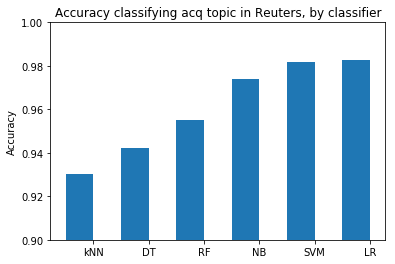

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

def test_and_graph(clfs,training_data,training_classifications,test_data,test_classifications):
    accuracies = []
    for clf in clfs:
        clf.fit(training_data,training_classifications)
        predictions = clf.predict(test_data)
        accuracies.append(accuracy_score(test_classifications,predictions))
    print (accuracies)
    p = plt.bar([num + 0.25 for num in range(len(clfs))], accuracies,0.5)
    plt.ylabel('Accuracy')
    plt.title('Accuracy classifying acq topic in Reuters, by classifier')
    plt.ylim([0.9,1])
    plt.xticks([num + 0.5 for num in range(len(clfs))], ('kNN', 'DT', 'RF', 'NB', 'SVM', 'LR'))
    plt.show()

test_and_graph(clfs,trn_data,trn_classes,test_data,test_classes)

The results are pretty close to what we saw using cross-validation, with Logistic Regression winning out over SVMs by a tiny margin, with an impressive accuracy of 98.3%.